# Particle plotting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ultraplot as uplt
from ipywidgets import interact
from ipywidgets import widgets

import psdist as ps
import psdist.plot as psv

In [2]:
uplt.rc["cmap.discrete"] = False
uplt.rc["colorbar.width"] = "1.2em"
uplt.rc["cycle"] = "538"
uplt.rc["cmap.sequential"] = "viridis"
uplt.rc["figure.facecolor"] = "white"
uplt.rc["grid"] = False

## Make distribution

In [3]:
def gen_points(ndim: int, size: int, seed: int = 0) -> np.ndarray:
    rng = np.random.default_rng(seed)

    cov_matrix = np.identity(ndim)
    for i in range(ndim):
        for j in range(i):
            cov_matrix[i, j] = cov_matrix[j, i] = rng.uniform(-0.2, 0.2)

    points = rng.multivariate_normal(np.zeros(ndim), cov_matrix, size=size)
    for _ in range(4):
        loc = rng.uniform(-3.0, +3.0, size=ndim)
        scale = rng.uniform(+0.5, +1.5, size=ndim)
        points = np.vstack(
            [points, rng.normal(loc=loc, scale=scale, size=(size, ndim))]
        )

    points = points - np.mean(points, axis=0)
    return points

## 1D plotting 

In [4]:
points = gen_points(ndim=6, size=1000, seed=0)
points = points[:, 0]

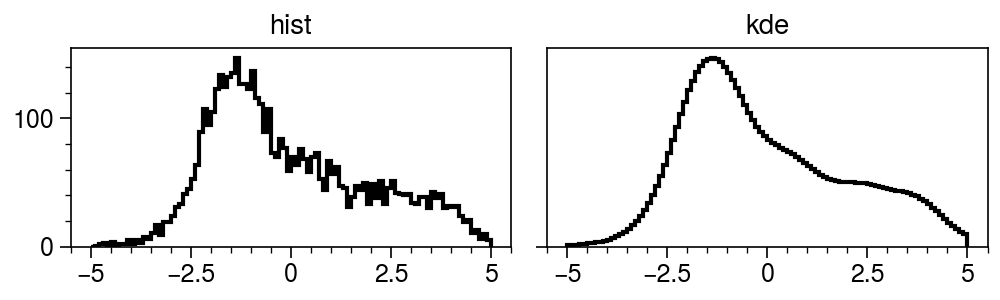

In [5]:
fig, axs = uplt.subplots(ncols=2, figsize=(5.0, 1.50))
for ax, kind in zip(axs, ["hist", "kde"]):
    psv.points.plot_1d(
        points,
        ax=ax,
        kind="step",
        kde=(kind == "kde"),
        bins=100,
        limits=(-5.0, 5.0),
        color="black",
    )
    ax.format(title=kind)
plt.show()

## 2D plotting

In [6]:
points = gen_points(ndim=6, size=1000, seed=0)
points = points[:, (0, 1)]
dims = ["x", "px"]

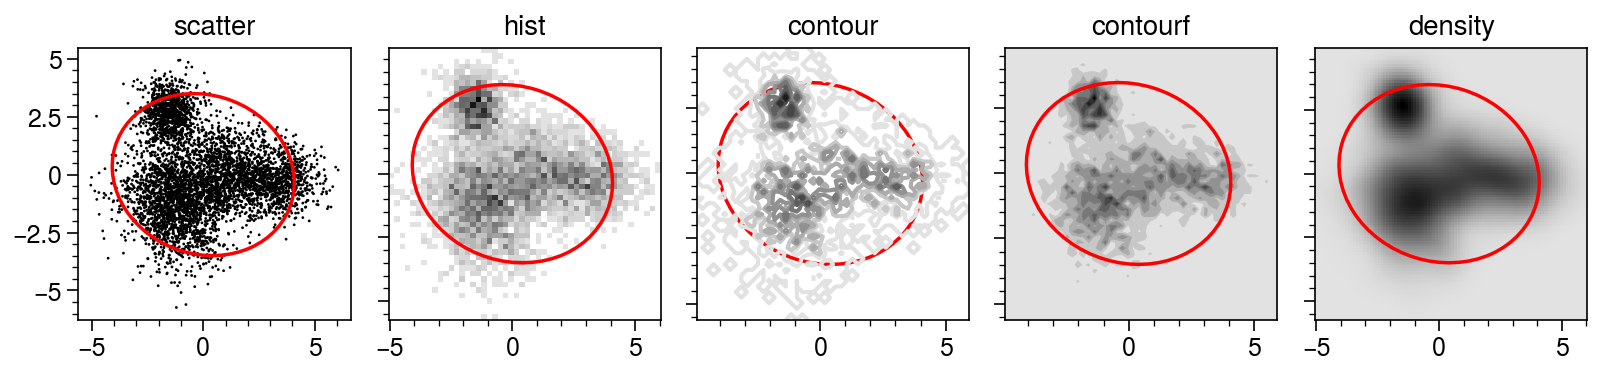

In [7]:
cmap = uplt.Colormap("mono", left=0.1)
kinds = ["scatter", "hist", "contour", "contourf", "density"]

fig, axs = uplt.subplots(ncols=len(kinds), figwidth=8.0)
for ax, kind in zip(axs, kinds):
    kws = dict()
    if kind == "scatter":
        kws["c"] = cmap(1.0)
        kws["s"] = 1.0
    else:
        kws["cmap"] = cmap

    if kind == "density":
        kws["bins"] = 100

    psv.points.plot(
        points,
        ax=ax,
        kind=kind,
        rms_ellipse=True,
        rms_ellipse_kws=dict(level=2.0, color="red"),
        **kws,
    )
    ax.format(title=kind)
plt.show()

## Enclosing sphere/ellipsoid 

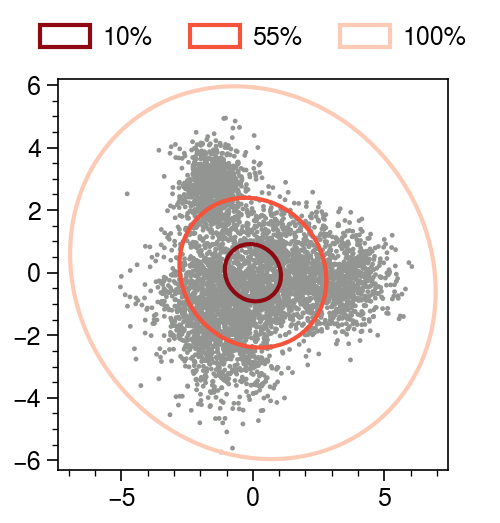

In [9]:
fig, ax = uplt.subplots(figwidth=2.5)
psv.points.plot(points, ax=ax, kind="scatter", c="gray", s=3.0)

fractions = np.linspace(0.10, 1.0, 3)
cmap = uplt.Colormap("reds", left=0.2, reverse=True)
for fraction in fractions:
    level = ps.enclosing_ellipsoid_radius(points, fraction=fraction)
    psv.points.plot_rms_ellipse(
        points,
        ax=ax,
        level=level,
        color=cmap(fraction),
        lw=1.5,
        label=f"{(100.0 * fraction):.0f}%",
    )
ax.legend(loc="t", ncols=3, framealpha=0)
plt.show()

## Spherical and ellipsoidal shell slices 

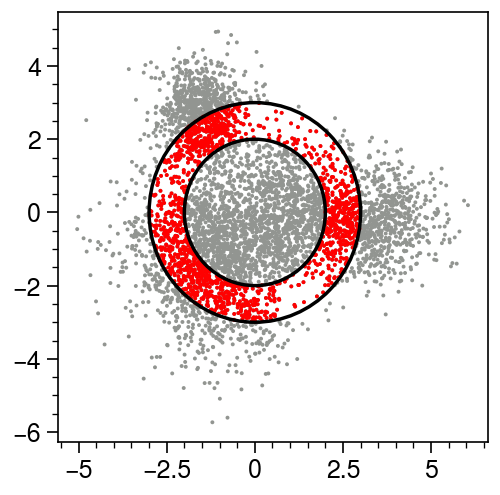

In [10]:
rmin = 2.0
rmax = 3.0
points_slice = ps.slice_sphere(points, rmin=rmin, rmax=rmax)

fig, ax = uplt.subplots(figwidth=2.5)
psv.points.plot(points, ax=ax, kind="scatter", color="grey")
psv.points.plot(points_slice, ax=ax, kind="scatter", color="red")
for r in [rmin, rmax]:
    psv.plot_circle(r=r, ax=ax)
plt.show()

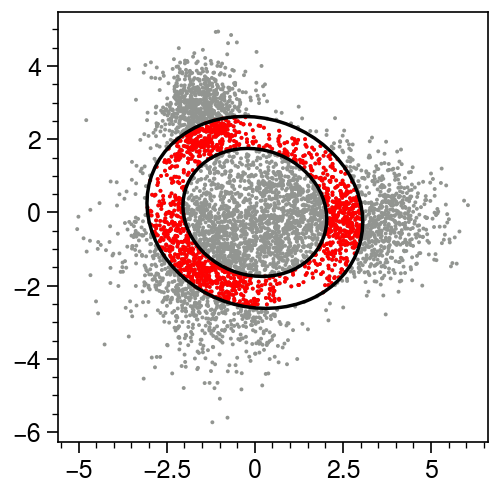

In [11]:
rmin = 1.0
rmax = 1.5
points_slice = ps.slice_ellipsoid(points, rmin=rmin, rmax=rmax)

fig, ax = uplt.subplots(figwidth=2.5)
psv.points.plot(points, ax=ax, kind="scatter", color="grey")
psv.points.plot(points_slice, ax=ax, kind="scatter", color="red")
for r in [rmin, rmax]:
    psv.points.plot_rms_ellipse(points, level=r, ax=ax)
plt.show()

In [12]:
@interact(radius=widgets.FloatRangeSlider(min=0.0, max=5.0))
def update(radius):
    (rmin, rmax) = radius
    points_slice = ps.slice_ellipsoid(points, axis=(0, 1), rmin=rmin, rmax=rmax)

    fig, ax = uplt.subplots(figwidth=2.5)
    psv.points.plot(points, ax=ax, kind="scatter", color="grey")
    psv.points.plot(points_slice, ax=ax, kind="scatter", color="red")
    for r in [rmin, rmax]:
        psv.points.plot_rms_ellipse(points, level=r, ax=ax)
    plt.show()

interactive(children=(FloatRangeSlider(value=(1.25, 3.75), description='radius', max=5.0), Output()), _dom_cla…

## Contour shell slice

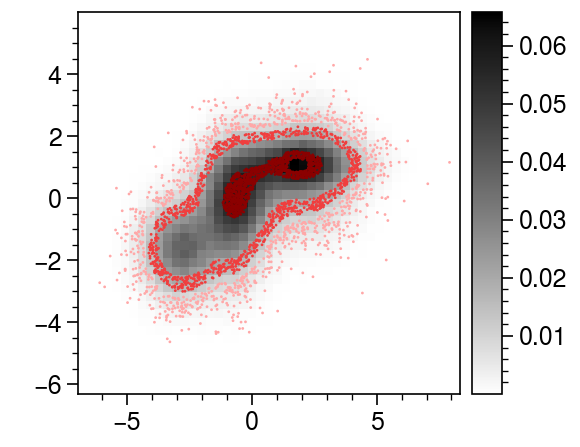

In [13]:
points = gen_points(ndim=6, size=100_000, seed=0)
points = points[:, (0, 1)]

bins = 45

fig, ax = uplt.subplots(figwidth=2.9)
psv.plot_points(
    points,
    ax=ax,
    kind="hist",
    process_kws=dict(scale="density"),
    bins=bins,
    cmap=uplt.Colormap("mono", left=0.0, right=1.0),
    colorbar=True,
    discrete=False,
)
for lmin, color in zip([0.0, 0.2, 0.8], ["red3", "red7", "darkred"]):
    lmax = lmin + 0.15
    psv.plot_points(
        ps.downsample(
            ps.slice_contour(
                points, lmin=lmin, lmax=lmax, hist_kws=dict(bins=bins)
            ),
            size=1000,
        ),
        ax=ax,
        kind="scatter",
        color=color,
        s=1.0,
    )
plt.show()

## Joint plot 

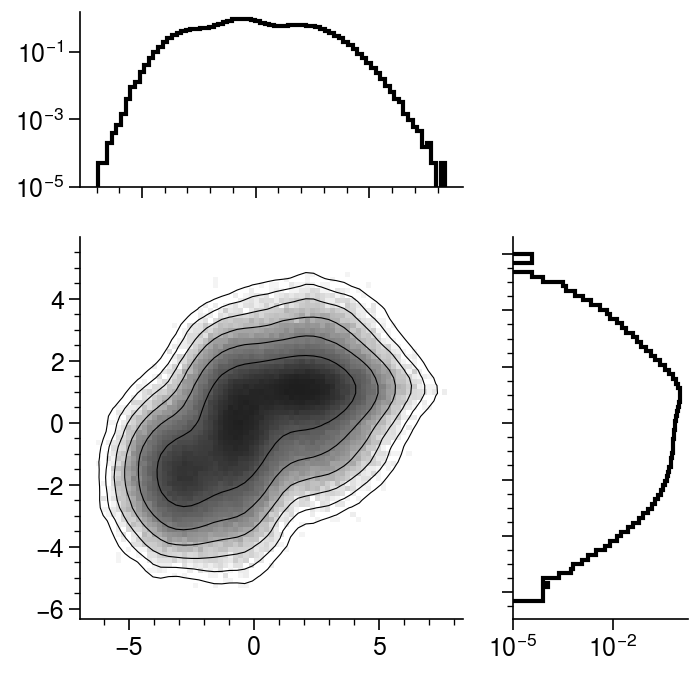

In [14]:
grid = psv.JointGrid(
    panel_kws=dict(space="2.0em", width="7.0em"),
    panel_fmt_kws_x=dict(yspineloc="left", xspineloc="bottom"),
    panel_fmt_kws_y=dict(yspineloc="left", xspineloc="bottom"),
    xspineloc="bottom",
    yspineloc="left",
    figwidth=3.5,
)
grid.plot_points(
    points,
    panel_plot_kws=dict(kind="step", color="black", scale="max"),
    panel_hist_kws=dict(bins=75),
    kind="hist",
    process_kws=dict(scale="density"),
    cmap=uplt.Colormap("grays", left=0.0, right=0.9),
    discrete=False,
    norm="log",
)
psv.plot_points(
    points,
    ax=grid.ax,
    bins=50,
    process_kws=dict(scale="max", blur=1.0),
    kind="contour",
    levels=(10.0 ** np.linspace(-3.0, 0.0, 7)),
    colors="black",
    lw=0.4,
)
ymin = 10.0**-5.0
ymax = None
grid.ax_panel_x.format(yformatter="log", yscale="log", ymin=ymin, ymax=ymax)
grid.ax_panel_y.format(xformatter="log", xscale="log", xmin=ymin, xmax=ymax)
plt.show()

## Radial histogram

In [15]:
ndim = 6
size = 100_000
dims = ["x", "px", "y", "py", "z", "pz"]
rng = np.random.default_rng(123)

points = gen_points(ndim=ndim, size=size)

In [16]:
X = points[:100_000, :].copy()
Y = points[:100_000, :].copy()

R = np.eye(ndim)
R[0:2, 0:2] = ps.utils.rotation_matrix(np.radians(+45.0))
R[2:4, 2:4] = ps.utils.rotation_matrix(np.radians(+20.0))
R[4:6, 4:6] = ps.utils.rotation_matrix(np.radians(-45.0))

for i in range(3):
    if i > 0:
        Y = ps.transform_linear(Y, R)
        Y = Y + rng.uniform(-3.5, 3.5, size=(1, Y.shape[1]))
        Y[:, 3] += 0.05 * Y[:, 1] ** 3 - 0.0002 * Y[:, 2] ** 4

Y -= np.mean(Y, axis=0)

Normalize by the volume of each spherical shell.

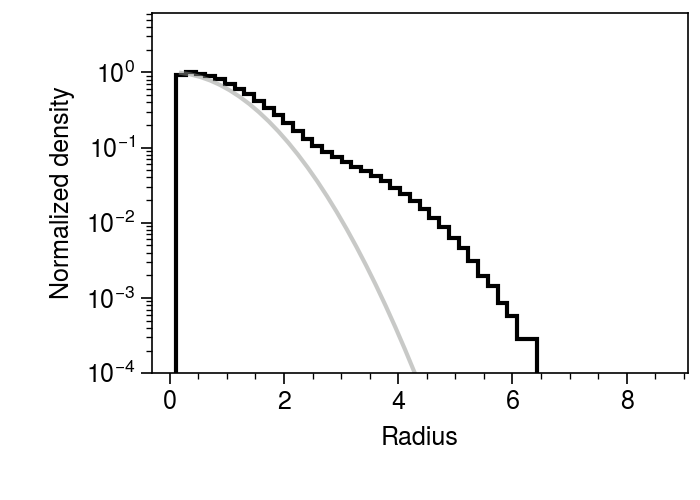

In [18]:
hist = ps.radial_histogram(points[:, :4], bins=50)
hist.values = hist.values / hist.values.max()

fig, ax = uplt.subplots(figsize=(3.5, 2.5))
psv.plot_hist_1d(hist, ax=ax, color="black", kind="step", label="data")
ax.plot(hist.coords, np.exp(-0.5 * hist.coords**2), color="gray", alpha=0.5, label="gaussian")
ax.format(
    yscale="log",
    yformatter="log",
    ymin=0.0001,
    xlabel="Radius",
    ylabel="Normalized density",
)
plt.show()

Define $\mathbf{r} = [x, y, z]^T$, $\mathbf{r}' = [p_x, p_y, p_z]^T$.

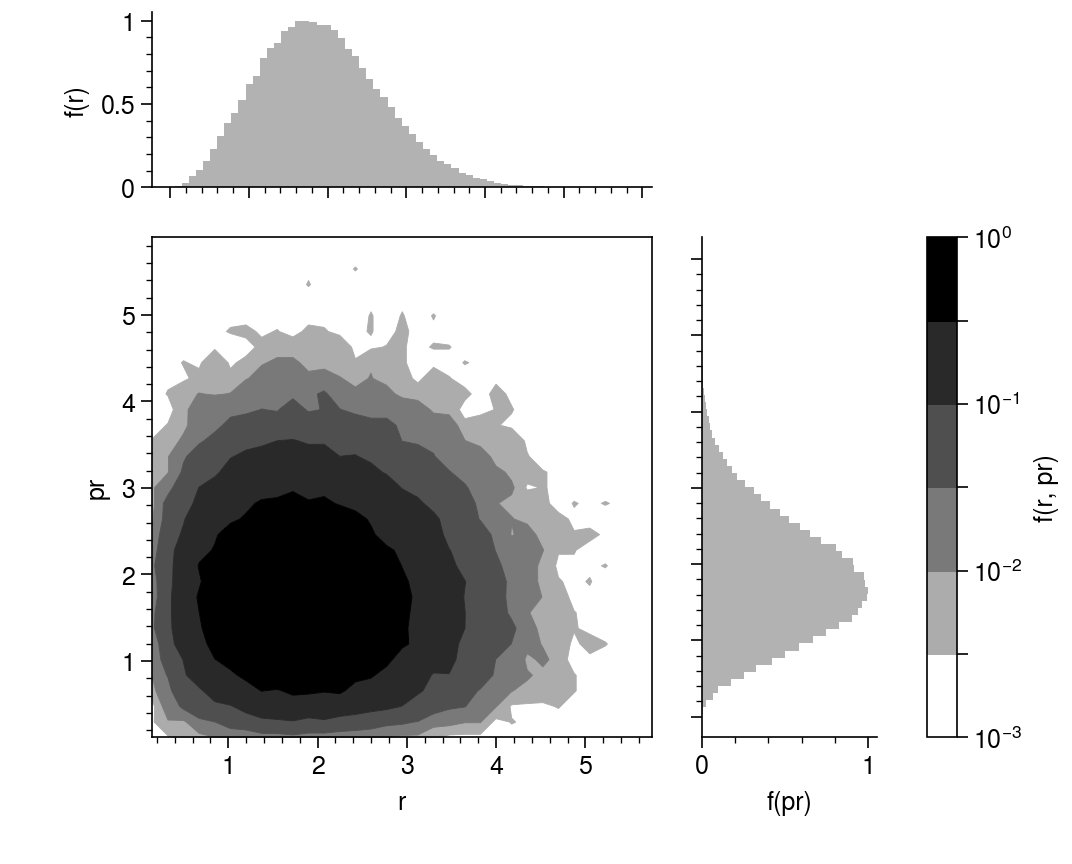

In [19]:
r  = ps.get_radii(X[:, (0, 2, 4)])
pr = ps.get_radii(X[:, (1, 3, 5)])
R = np.vstack([r, pr]).T

grid = psv.JointGrid(
    panel_kws=dict(space="2.0em", width="7.0em"),
    panel_fmt_kws_x=dict(yspineloc="left", xspineloc="bottom", ylabel="f(r)"),
    panel_fmt_kws_y=dict(yspineloc="left", xspineloc="bottom", xlabel="f(pr)"),
)
grid.plot_points(
    R,
    bins=33,
    panel_plot_kws=dict(scale="max", fill=True, color="black", alpha=0.3),
    process_kws=dict(scale="max"),
    offset=1.0,
    kind="contourf",
    norm="log",
    vmax=1.0,
    cmap="mono",
    colorbar=True,
    colorbar_kw=dict(label="f(r, pr)"),
)
grid.ax.format(xlabel="r", ylabel="pr")
plt.show()

## Corner plot 

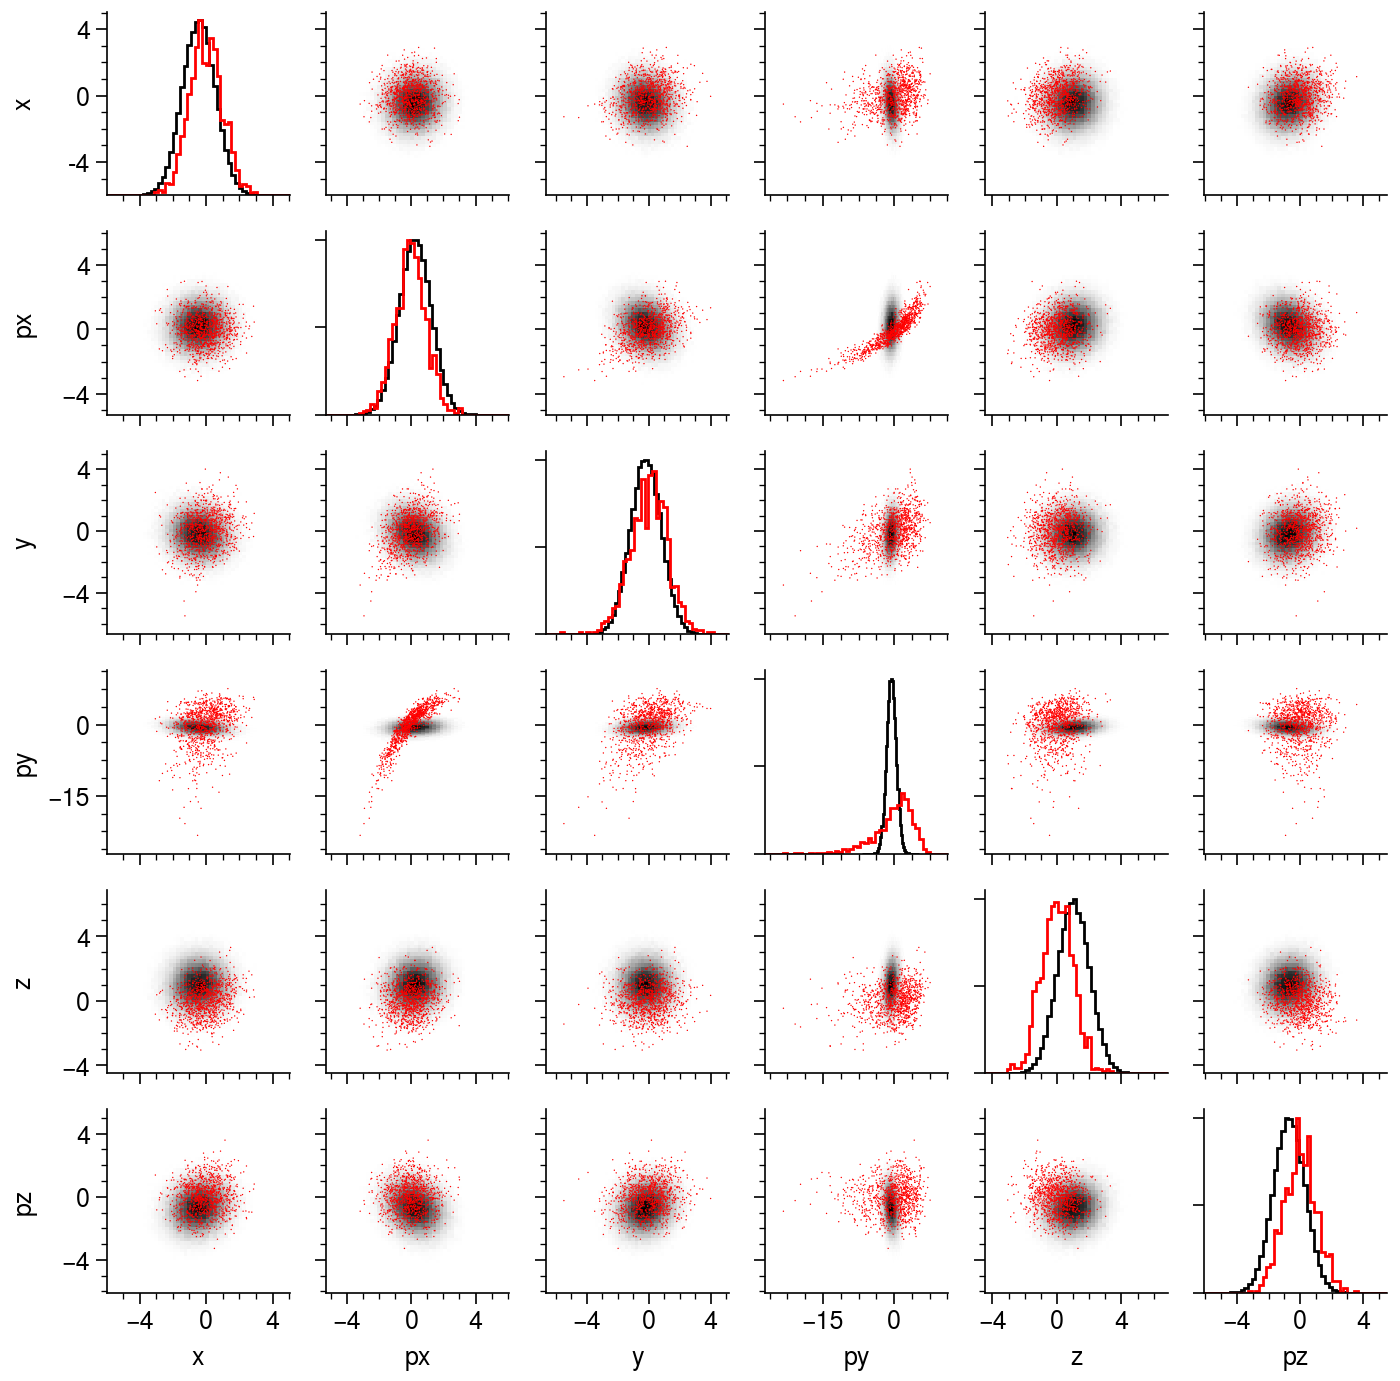

In [20]:
grid = psv.CornerGrid(ndim=ndim, diag=True, corner=False, figwidth=7.0, diag_frozen=False)
grid.set_labels(dims)
grid.plot_points(
    X,
    kind="hist",
    bins=50,
    lower=True,
    upper=True,
    diag_kws=dict(color="black"),
    cmap="mono",
)
grid.plot_points(
    Y[:1000, :],
    kind="scatter",
    lower=True,
    upper=True,
    diag_kws=dict(color="red"),
    color="red",
    s=0.25
)
plt.show()

Or call `plot_corner`.

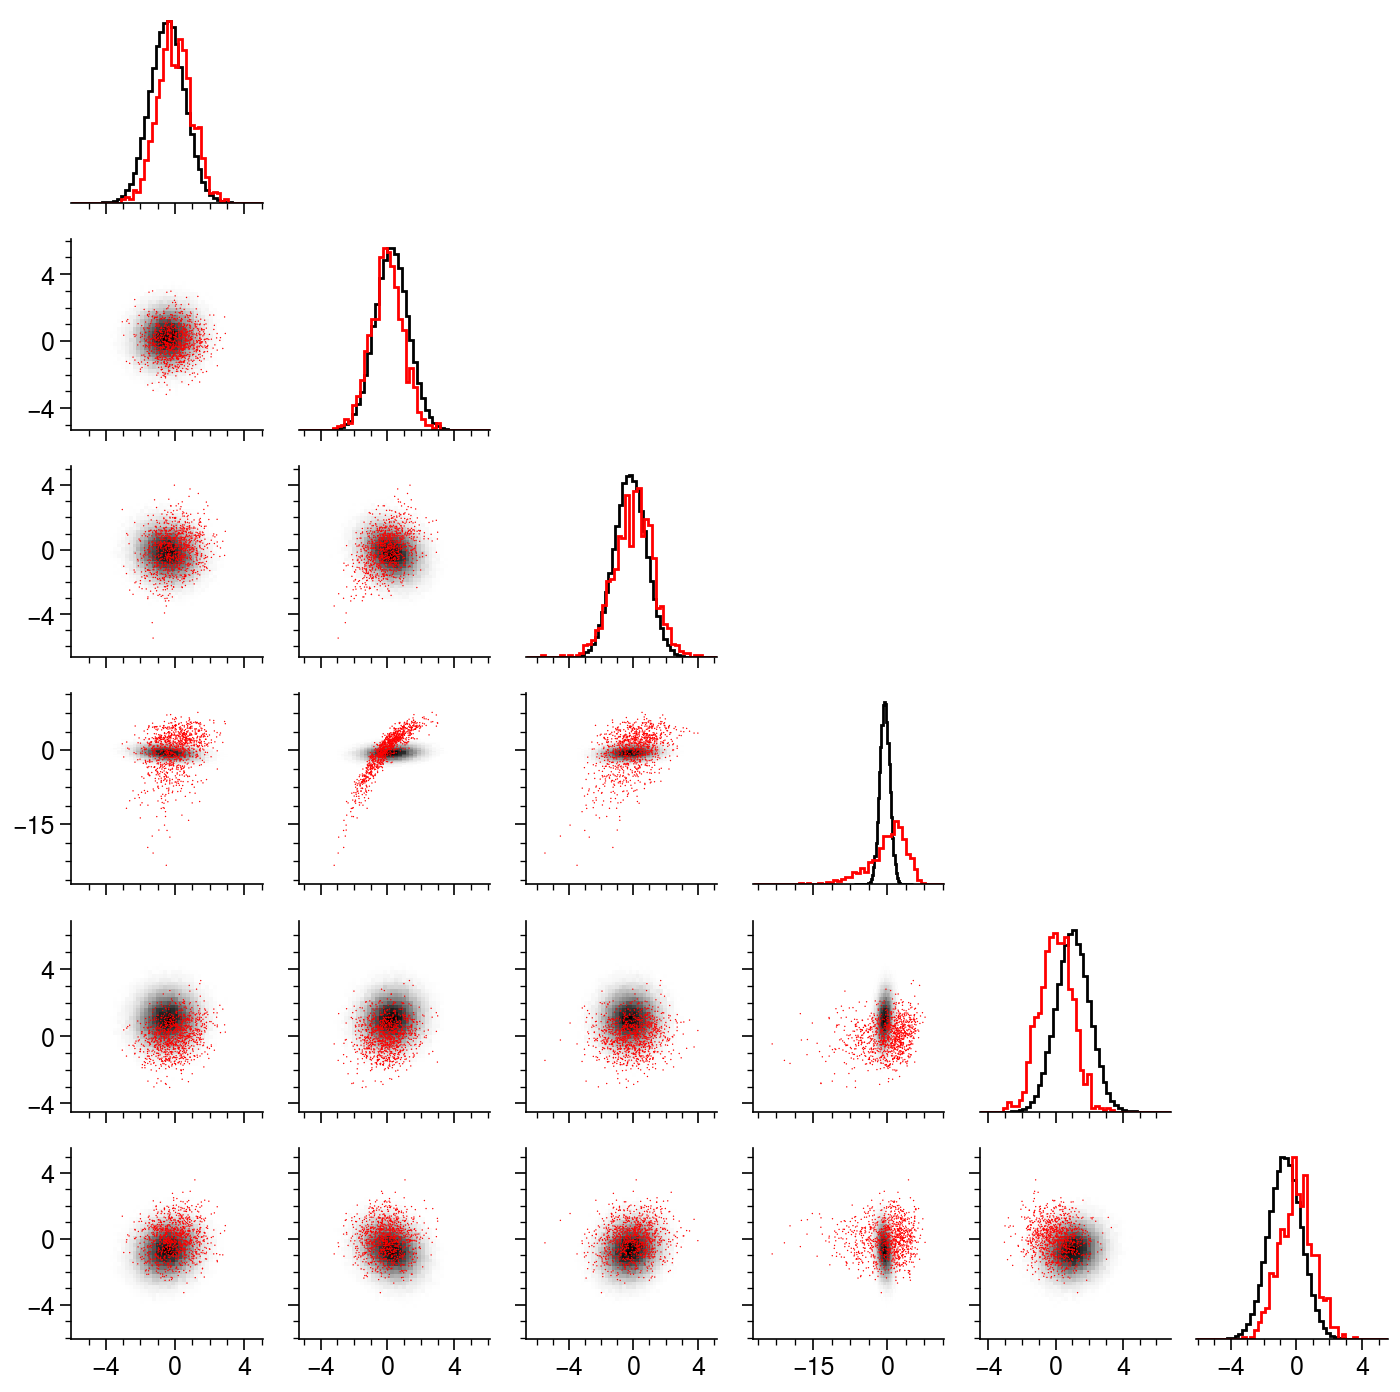

In [21]:
grid = psv.plot_corner(X, grid_kws=dict(figwidth=7.0), cmap="mono")
grid.plot_points(Y[:1000], kind="scatter", color="red", s=0.25, diag_kws=dict(color="red"))

## Slice matrix plot 

[To do...]

## Interactive slicing

### 1D 

In [ ]:
# X = points.copy()
# X = X - np.mean(X, axis=0)
# Y = Y - np.mean(Y, axis=0)
# data = [
#     [Y, X, 2.0 * X],
#     [X, -Y, -2.0 * Y],
# ]

In [ ]:
# psv.points.interactive_slice_1d(
#     data=data,
#     dims=dims,
#     slice_type="range",  # {"int", "range"}
#     options=dict(
#         alpha=True,
#         auto_plot_res=False,
#         kind=True,
#         log=True,
#         normalize=False,
#         scale=False,
#     ),
#     share_limits=False,
#     legend=True,
#     labels=None,
#     cycle="538",
#     fig_kws=dict(figsize=(5.0, 2.0)),
# )

### 2D 

In [ ]:
# plot_kws = dict(
#     profx=True,
#     profy=True,
#     prof_kws=dict(color="white"),
#     process_kws=dict(norm="max"),
#     autolim_kws=dict(pad=0.1),
#     offset=1.0,
#     colorbar=True,
#     colorbar_kw=dict(tickminor=True, width="1.2em"),
# )

In [ ]:
# psv.points.interactive_slice_2d(
#     data=data,
#     limits=None,
#     share_limits=1,
#     default_axis=(0, 1),
#     slice_type="range",
#     plot_res=64,
#     slice_res=16,
#     dims=dims,
#     units=None,
#     options=dict(
#         auto_plot_res=False,
#         discrete=True,
#         ellipse=True,
#         log=True,
#         mask=False,
#         normalize=True,
#         profiles=True,
#     ),
#     fig_kws=dict(toplabels=["left", "right"], space=6.0),
#     **plot_kws,
# )